In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.7.3
IPython 7.4.0

numpy 1.14.5
scipy 1.3.1
pandas 0.24.2
matplotlib 3.0.3
statsmodels 0.9.0
sklearn 0.20.3

compiler   : GCC 7.3.0
system     : Linux
release    : 4.4.0-46-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   :


In [57]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import re
import pickle
import functools
import itertools
from collections import Counter, deque
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
from scipy.sparse import csr_matrix, vstack
import datatable as dtbl
import datetime
from scipy import stats
from statsmodels.stats.proportion import proportion_confint

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1 Предобработка данных

**Посмотрим на один из файлов с данными о посещенных пользователем (номер 31) веб-страницах.**

In [4]:
PATH_TO_DATA = 'data/'

In [17]:
user31_data = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                       '10users/user0031.csv'))

In [6]:
user31_data.head()

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net
3,2013-11-15 08:12:17,www.google.com
4,2013-11-15 08:12:18,www.laposte.net


**Поставим задачу классификации: идентифицировать пользователя по сессии из 10 подряд посещенных сайтов. Объектом в этой задаче будет сессия из 10 сайтов, последовательно посещенных одним и тем же пользователем, признаками – индексы этих 10 сайтов (чуть позже здесь появится "мешок" сайтов, подход Bag of Words). Целевым классом будет id пользователя.**

### <center>Пример для иллюстрации</center>
**Пусть пользователя всего 2, длина сессии – 2 сайта.**

<center>user0001.csv</center>
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">timestamp</th>
    <th class="tg-031e">site</th>
  </tr>
  <tr>
    <td class="tg-031e">00:00:01</td>
    <td class="tg-031e">vk.com</td>
  </tr>
  <tr>
    <td class="tg-yw4l">00:00:11</td>
    <td class="tg-yw4l">google.com</td>
  </tr>
  <tr>
    <td class="tg-031e">00:00:16</td>
    <td class="tg-031e">vk.com</td>
  </tr>
  <tr>
    <td class="tg-031e">00:00:20</td>
    <td class="tg-031e">yandex.ru</td>
  </tr>
</table>

<center>user0002.csv</center>
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">timestamp</th>
    <th class="tg-031e">site</th>
  </tr>
  <tr>
    <td class="tg-031e">00:00:02</td>
    <td class="tg-031e">yandex.ru</td>
  </tr>
  <tr>
    <td class="tg-yw4l">00:00:14</td>
    <td class="tg-yw4l">google.com</td>
  </tr>
  <tr>
    <td class="tg-031e">00:00:17</td>
    <td class="tg-031e">facebook.com</td>
  </tr>
  <tr>
    <td class="tg-031e">00:00:25</td>
    <td class="tg-031e">yandex.ru</td>
  </tr>
</table>

Идем по 1 файлу, нумеруем сайты подряд: vk.com – 1, google.com – 2 и т.д. Далее по второму файлу. 

Отображение сайтов в их индесы должно получиться таким:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">site</th>
    <th class="tg-yw4l">site_id</th>
  </tr>
  <tr>
    <td class="tg-yw4l">vk.com</td>
    <td class="tg-yw4l">1</td>
  </tr>
  <tr>
    <td class="tg-yw4l">google.com</td>
    <td class="tg-yw4l">2</td>
  </tr>
  <tr>
    <td class="tg-yw4l">yandex.ru</td>
    <td class="tg-yw4l">3</td>
  </tr>
  <tr>
    <td class="tg-yw4l">facebook.com</td>
    <td class="tg-yw4l">4</td>
  </tr>
</table>

Тогда обучающая выборка будет такой (целевой признак – user_id):
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-s6z2{text-align:center}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-hgcj{font-weight:bold;text-align:center}
.tg .tg-amwm{font-weight:bold;text-align:center;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-hgcj">session_id</th>
    <th class="tg-hgcj">site1</th>
    <th class="tg-hgcj">site2</th>
    <th class="tg-amwm">user_id</th>
  </tr>
  <tr>
    <td class="tg-s6z2">1</td>
    <td class="tg-s6z2">1</td>
    <td class="tg-s6z2">2</td>
    <td class="tg-baqh">1</td>
  </tr>
  <tr>
    <td class="tg-s6z2">2</td>
    <td class="tg-s6z2">1</td>
    <td class="tg-s6z2">3</td>
    <td class="tg-baqh">1</td>
  </tr>
  <tr>
    <td class="tg-s6z2">3</td>
    <td class="tg-s6z2">3</td>
    <td class="tg-s6z2">2</td>
    <td class="tg-baqh">2</td>
  </tr>
  <tr>
    <td class="tg-s6z2">4</td>
    <td class="tg-s6z2">4</td>
    <td class="tg-s6z2">3</td>
    <td class="tg-baqh">2</td>
  </tr>
</table>

Здесь 1 объект – это сессия из 2 посещенных сайтов 1-ым пользователем (target=1). Это сайты vk.com и google.com (номер 1 и 2). И так далее, всего 4 сессии. Пока сессии у нас не пересекаются по сайтам, то есть посещение каждого отдельного сайта относится только к одной сессии.

Реализуем функцию *prepare_train_set*, которая принимает на вход путь к каталогу с csv-файлами *path_to_csv_files* и параметр *session_length* – длину сессии, а возвращает 2 объекта:
- DataFrame, в котором строки соответствуют уникальным сессиям из *session_length* сайтов, *session_length* столбцов – индексам этих *session_length* сайтов и последний столбец – ID пользователя
- частотный словарь сайтов вида {'site_string': [site_id, site_freq]}, например для недавнего игрушечного примера это будет {'vk.com': (1, 2), 'google.com': (2, 2), 'yandex.ru': (3, 3), 'facebook.com': (4, 1)}

In [7]:
def prepare_train_set(path, foldname, session_length=10):
    
    paths_to_files = sorted( glob(os.path.join(PATH_TO_DATA, foldname + '/*.csv')) )
    files = sorted( os.listdir( os.path.join(PATH_TO_DATA, foldname)) )
    id_arr =[ np.array(re.findall(r'\d+', i), dtype=np.int) \
                  for i in list(filter(lambda x: x.endswith('.csv'), files)) ]
    
    lu = []
    for user in tqdm_notebook(paths_to_files):
        data = dtbl.fread(user)
        res = data[:, 'site'].to_list()
        lu.append(res)
    merged = list( itertools.chain(*lu) )    
    dct_site = dict( functools.reduce(lambda x, y: Counter(x)+ Counter(y), merged) )
    
    for num, item in enumerate(dct_site.items()):
        dct_site[item[0]] = (num+1, item[1])
        
        
    def site_idx_arr(lst):
        nrows = np.ceil(len(lst)/session_length)
        zero_arr = np.zeros( (nrows*session_length).astype('int') ) 
        for i, site in enumerate(lst):
            zero_arr[i] = dct_site[site][0]
            zero_reshaped = zero_arr.reshape( int(nrows) , session_length )
        return zero_reshaped
    
    def add_id(site_arr, id_arr):
        res = np.concatenate([site_arr, np.ones( (site_arr.shape[0], 1) )*id_arr.item()],
                             axis=1).astype('int')
        return res
        
    
    temp_arr = list(map(site_idx_arr, merged))
    temp = [add_id(s, i) for (s, i) in zip(temp_arr, id_arr)] 
    
    sites = ['site%s' % i for i in range(1, session_length+1)]
    sites.append('user_id')
    data_toy = pd.DataFrame(np.vstack(temp), columns=sites)
    
    return data_toy, dct_site

**Сверим 3 первых файла с агрегирующей функцией**

In [8]:
!cat $PATH_TO_DATA/10users/user0031.csv

timestamp,site
2013-11-15 08:12:07,fpdownload2.macromedia.com
2013-11-15 08:12:17,laposte.net
2013-11-15 08:12:17,www.laposte.net
2013-11-15 08:12:17,www.google.com
2013-11-15 08:12:18,www.laposte.net
2013-11-15 08:12:38,www.laposte.net
2013-11-15 08:12:39,www.google.com
2013-11-15 08:12:39,www.laposte.net
2013-11-15 08:12:40,match.rtbidder.net
2013-11-15 08:12:40,www.laposte.net
2013-11-15 08:12:40,x2.vindicosuite.com
2013-11-15 08:12:41,rp.gwallet.com
2013-11-15 08:12:41,pool-eu-ie.creative-serving.com
2013-11-15 08:15:24,dl.javafx.com
2013-11-15 08:17:09,www.laposte.net
2013-11-15 08:17:09,ajax.googleapis.com
2013-11-15 08:17:10,api.dailymotion.com
2013-11-15 08:17:13,i1-js-14-3-01-11074-266576264-i.init.cedexis-radar.net
2013-11-15 08:17:16,limelight.cedexis.com
2013-11-15 08:17:24,webmail.laposte.net
2013-11-15 08:17:25,webmail.laposte.net
2013-11-15 08:17:25,www.google.com
2013-11-15 08:17:39,webmail.laposte.net
2013-11-15 08:17:40,webmail.laposte.net
2013-11-15 08:21:42,www.face

**Применим полученную функцию к данным по 10 пользователям.**

In [18]:
train_data_10users, site_freq_10users = prepare_train_set(path = PATH_TO_DATA, 
                                                          foldname = '10users', 
                                                          session_length=10)

print("Уникальных сессий: %d" % (train_data_10users.shape[0]))
print("Уникальных сайтов: %d" % (len(site_freq_10users)))


Уникальных сессий: 14061
Уникальных сайтов: 4913


In [10]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
0,1,2,3,4,3,3,4,3,5,3,31
1,6,7,8,9,3,10,11,12,13,14,31
2,14,4,14,14,15,16,6,17,18,14,31
3,19,20,19,14,14,14,14,21,22,23,31
4,24,14,15,25,26,27,28,29,30,29,31


**Применим полученную функцию к данным по 150 пользователям.**

In [19]:
train_data_150users, site_freq_150users = prepare_train_set(path = PATH_TO_DATA, 
                                                          foldname = '150users', 
                                                          session_length=10)

print("Уникальных сессий: %d" % (train_data_150users.shape[0]))
print("Уникальных сайтов: %d" % (len(site_freq_150users)))


Уникальных сессий: 137019
Уникальных сайтов: 27797


**Сохраним частотные словари сайтов для 10 и 150 пользователей.**

In [20]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'wb') as site_freq_10users_pkl:
    pickle.dump(site_freq_10users, site_freq_10users_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'), 'wb') as site_freq_150users_pkl:
    pickle.dump(site_freq_150users, site_freq_150users_pkl, protocol=2)

## 1.1 Модель мешка слов

Идея подхода заключается в том, что в качестве признакового описания сессии используется вектор, длинна которого равна количеству различных сайтов в наборе данных, а значение координаты вектора равно количеству посещений этого сайта в течение сессии. При этом мы пренебрегаем порядком посещения сайтов внутри сессии, однако признаковое пространство становится метрическим и мы можем применять стандартные подходы машинного обучения. Так как количество различных сайтов в наборе данных сильно превышает длинну сессии, то в построенной матрице признаков будет очень много нулей, т.е. она будет разреженной. Выбранная реализация `scipy.sparse.csr_matrix` позволяет экономно использовать память для хранения разреженной матрицы. Функция `to_sparse` осуществляет преобразование исходной матрицы сессий в разреженную матрицу модели мешка слов.

In [13]:
def to_sparse(matrix):
    row_ind = []
    col_ind = []
    data = []
    for i, row in enumerate(matrix):
        unique_elements, counts_elements = np.unique(row, return_counts=True)
        for index, element in np.ndenumerate(unique_elements):
            if element > 0:
                row_ind.append(i)
                col_ind.append(element - 1)
                data.append(counts_elements[index])
    
    return csr_matrix((data, (row_ind, col_ind)))

**Результат применения модели мешка слов к набору данных для 10 пользователей:**

In [14]:
to_sparse(train_data_10users.iloc[:, :-1].values).todense()

matrix([[1, 1, 5, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Для более полного анализа необходимо при разделении данных на сессии предусмотреть возможность перекрытия сессий. Для этого применяется концепция скользящего окна, размер которого задаёт смещение последовательных сессий относительно друг друга. Разбиение данных на сессии с учётом скользящего окна реализовано в функции `prepare_sparse_train_set_window`.

In [33]:
def read_lines(file_obj, site_freq, buffer, n):
    for i in range(n):
        line = file_obj.readline()
        if not line:
            buffer.extend([(None, 0)] * (n - i))    
            return i
        
        comma_index = line.index(',')
        timestamp = line[:comma_index]
        site_url = line[comma_index + 1:-1]
        buffer.append((datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S'), site_freq[site_url][0]))
    
    return n


def prepare_sparse_train_set_window(path_to_csv_files, foldname, site_freq_path, 
                                    session_length=10, window_size=10):
    
    with open(site_freq_path, 'rb') as file_obj:
        site_freq = pickle.load(file_obj)
    
    buffer = deque(maxlen=session_length)
    data = []
    row_ind = []
    col_ind = []
    y = []
    user_id = 1
    session_id = 0
    for file_path in sorted(glob(os.path.join(path_to_csv_files, foldname, '*.csv'))):
        with open(file_path, 'r') as file_obj:
            file_obj.readline()
            n = read_lines(file_obj, site_freq, buffer, session_length)
            if n > 0:
                counter = Counter([data[1] for data in buffer])
                counter.pop(0, None)
                if len(counter) > 0:
                    for site_id, frequency in counter.items():
                        row_ind.append(session_id)
                        col_ind.append(site_id - 1)
                        data.append(frequency)
                    
                    session_id += 1
                    y.append(user_id)
            
            while n >= window_size:
                n -= window_size - read_lines(file_obj, site_freq, buffer, window_size)
                counter = Counter([data[1] for data in buffer])
                counter.pop(0, None)
                if len(counter) > 0:
                    for site_id, frequency in counter.items():
                        row_ind.append(session_id)
                        col_ind.append(site_id - 1)
                        data.append(frequency)
                    
                    session_id += 1
                    y.append(user_id)
        
        user_id += 1
    
    return csr_matrix((data, (row_ind, col_ind))), np.array(y)

Подготовим матрицы признаков для различных значений длины сессии и ширины окна. В разделе 2 эти матрицы будут использованы при обучении моделей и выбора параметров, обеспечиваюших лучшее качество моделей. Матрицы строятся на основе данных для 10 и 150 пользователей. Используемые значения длинны сессии и ширины скользящего окна:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">session_length -&gt;<br>window_size <br></th>
    <th class="tg-031e">5</th>
    <th class="tg-031e">7</th>
    <th class="tg-031e">10</th>
    <th class="tg-031e">15</th>
  </tr>
  <tr>
    <td class="tg-031e">5</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">7</td>
    <td class="tg-031e"></td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">10</td>
    <td class="tg-031e"></td>
    <td class="tg-031e"></td>
    <td class="tg-031e"><font color='green'>v</font></td>
    <td class="tg-031e">v</td>
  </tr>
</table>

In [34]:
for num_users in [10, 150]:
    for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
        if window_size <= session_length:
            X_sparse, y = prepare_sparse_train_set_window(                
                        path_to_csv_files = PATH_TO_DATA, 
                        foldname = str(num_users)+'users',
                        site_freq_path = os.path.join(PATH_TO_DATA,'site_freq_'+str(num_users)+'users.pkl'),
                        session_length=session_length, 
                        window_size=window_size)

            with open(os.path.join(PATH_TO_DATA, 
                     'X_sparse_'+str(num_users)+'users_s'+str(session_length)\
                                   +'_w'+str(window_size)+'.pkl'), 'wb') as x:
                  pickle.dump(X_sparse, x, protocol=2)
                    
            with open(os.path.join(PATH_TO_DATA, 
                     'y_'+str(num_users)+'users_s'+str(session_length)\
                                   +'_w'+str(window_size)+'.pkl'), 'wb') as target:
                  pickle.dump(y, target, protocol=2)             

# 2 Проверка гипотез

In [35]:
train_data_10users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14061 entries, 0 to 14060
Data columns (total 11 columns):
site1      14061 non-null int64
site2      14061 non-null int64
site3      14061 non-null int64
site4      14061 non-null int64
site5      14061 non-null int64
site6      14061 non-null int64
site7      14061 non-null int64
site8      14061 non-null int64
site9      14061 non-null int64
site10     14061 non-null int64
user_id    14061 non-null int64
dtypes: int64(11)
memory usage: 1.2 MB


**Распределение целевого класса:**

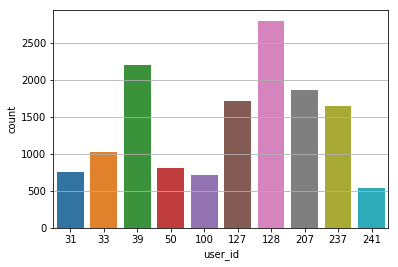

In [43]:
sns.countplot(train_data_10users['user_id'], grid());

**Посчитаем распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов.**

In [54]:
num_unique_sites = pd.Series( [np.unique(train_data_10users.values[i, :-1]).shape[0] 
                              for i in range(train_data_10users.shape[0])] )

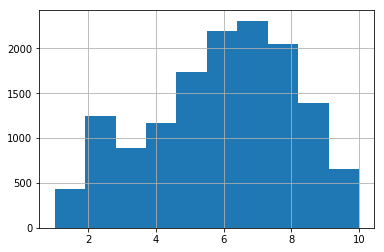

In [55]:
num_unique_sites.hist();

**Проверим с помощью QQ-плота и критерия Шапиро-Уилка, что эта величина распределена нормально**

In [85]:
shap = list(map(lambda x: round(x, 3), stats.shapiro(num_unique_sites.value_counts().values)))
print(shap)

[0.953, 0.701]


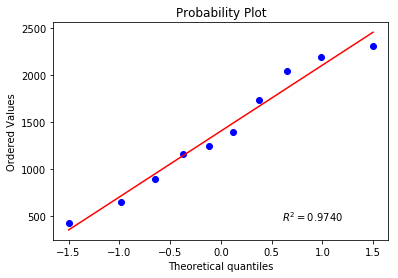

In [60]:
stats.probplot(num_unique_sites.value_counts().values, dist="norm", plot=pylab, rvalue=True);

*Согласно критерия Шапиро-Уилка распределение уникальных сайтов ненормально. Визуально на графике видны небольшие отклонения от нормальности.*

**Проверим гипотезу о том, что пользователь хотя бы раз зайдет на сайт, который он уже ранее посетил в сессии из 10 сайтов. Проверим с помощью биномиального критерия для доли, что доля случаев, когда пользователь повторно посетил какой-то сайт (то есть число уникальных сайтов в сессии < 10) велика: больше 95% (альтернатива тому, что доля равна 95% – одностороняя).**

In [62]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')
pi_val = stats.binom_test( sum(has_two_similar), len(has_two_similar), 0.95, alternative='greater') 
print('p-value: ', round(pi_val, 3))

p-value:  0.022


In [67]:
wilson_interval = proportion_confint(sum(has_two_similar), len(has_two_similar),
                                     alpha=0.05, method = 'wilson')

print('95% доверительный интервал Уилсона для доли случаев,\
 когда пользователь повторно посетил какой-то сайт:', round(wilson_interval[0], 3),
                                                      round(wilson_interval[1], 3))

95% доверительный интервал Уилсона для доли случаев, когда пользователь повторно посетил какой-то сайт: 0.95 0.957


**Построим распределение частоты посещения сайтов (сколько раз тот или иной сайт попадается в выборке) для тех, которые были посещены как минимум 1000 раз.**

In [68]:
st = ['site%s' % i for i in range(1, 11)]
dct_st = dict( np.sum([Counter(train_data_10users[s].values ) for s in st]))
over_kilo = dict(filter(lambda elem: elem[1] > 999, dct_st.items()))

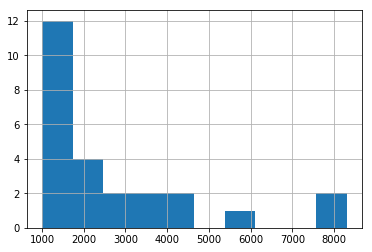

In [69]:
pd.Series(over_kilo).hist();

**Построим 95% доверительный интервал для средней частоты появления сайта в выборке (во всей, уже не только для тех сайтов, что были посещены как минимум 1000 раз) на основе bootstrap. Используем столько же bootstrap-подвыборок, сколько сайтов оказалось в исходной выборке по 10 пользователям. Частоту появления нуля (сайт с индексом 0 появлялся там, где сессии были короче 10 сайтов) не включаем.**

In [70]:
def get_bootstrap_samples(data, n_samples, random_seed=17):
    np.random.seed(random_seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [75]:
d = sorted(dct_st.values(), reverse=True)
n_mean = list(map(np.mean, get_bootstrap_samples(np.array(d), len(d))))
st_intervals = stat_intervals(n_mean, 0.05)

print('95% доверительный интервал для средней частоты появления сайта в выборке: ', 
      list(map(lambda x: x.round(3), st_intervals)) )

95% доверительный интервал для средней частоты появления сайта в выборке:  [22.514, 35.755]


# 3 Построение дополнительных признаков

Признаки, полученные с помощью реализации идеи мешка слов - сайтов, не используют временную часть информации, которая содержится в исходных данных. Учёт этой информации потенциально может улучшить качество моделей. Для этого строим дополнительные признаки на основе временных меток посещения сайтов пользователями. Также попробуем построить новые признаки, не связанные со временем, но в некотором смысле агрегирующие статистику посещения сайтов пользователями.

Дополнительные признаки:
- **session_timespan** – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- **#unique_sites** – число уникальных сайтов в сессии
- **start_hour** – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- **day_of_week** – день недели (то есть день недели в записи минимального timestamp среди десяти)
- **morning, day, evening, night** – время суток начала сессии (ночь, утро, день, вечер)
- **is_weekend** – выходной
- **year_month** – год\_месяц (например: `201205`)
- **isinTop** – находится ли сайт в топ-30

Извлечение дополнительных признаков реализовано в функции `feature_engineering`.

In [86]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

feature_names_new = ['morning', 'day', 'evening', 'night', 'is_weekend', 'year_month', 'isinTop']

def feature_engineering(path_to_csv_files, foldname, site_freq_path, 
                        features=None, session_length=10):
    
    cols = feature_names_new
    window_size = 10
    dct = pd.read_pickle(site_freq_path)
    paths_to_files = np.sort( glob(os.path.join(path_to_csv_files, foldname + '/*.csv')) )
    files = np.sort( os.listdir( os.path.join(path_to_csv_files, foldname)) )
    user_ids =[ np.array(re.findall(r'\d+', i), dtype=np.int32) \
                  for i in list(filter(lambda x: x.endswith('.csv'), files)) ]
    
    top30 = pd.DataFrame(dct).T.reset_index().iloc[:, [1, 2]] \
                    .sort_values(by=1, ascending=False).head(30).values
    
    lu, ts = [], []
    for user in paths_to_files:
        data = dtbl.fread(user)
        # download 'site'
        res = data[:, 'site'].to_list()
        lu.append(res)
    
        # download 'timestamp'
        timestamp = pd.read_csv(user, usecols=['timestamp'], parse_dates=['timestamp'])
        ts.append(timestamp)
    
    merged = list( itertools.chain(*lu) ) 
    
    def site_name2id(lst_sites):
        '''replace names of sites with IDs ones
        '''
        arr = []
        [ arr.append(dct[site][0]) for site in lst_sites ]
        return arr
    
    id_arr = list( map(site_name2id, merged) )
    ziped = zip(id_arr, ts, user_ids)
    
    def count_site_arr(data): 
        
        site_arr = data[0]
        ts_arr = data[1]
        uid = data[2]
        
        len_arr = len(site_arr)
        nrows = np.ceil( len_arr / window_size ).astype(np.int32)
        
        # get sites
        ind = np.arange(session_length)[None, :] + np.arange(0, len_arr, window_size)[:, None]
        site_pad = np.pad(site_arr, ( 0, nrows*session_length - len_arr ), 'constant')
        site_id = site_pad[ind]
        
        # get ts diff
        time_lst = np.array_split( ts_arr.values.flatten(),
                                    np.array(np.arange(1, nrows + 1) * [session_length]) )[:-1]        
        temp_diff = list(map(np.diff, time_lst))
        diff_shape = np.int32( np.hstack(temp_diff).shape[0] )
        diff_pad = np.pad( np.hstack(temp_diff), 
                         ( 0, nrows * (session_length - 1) - diff_shape  ), 'constant')
        diff_arr = np.int32(diff_pad.astype(np.timedelta64(1, 's'))) \
                            .reshape(nrows, np.int32(diff_pad.shape[0] / nrows) )        
                
        # get session_timespan
        sess_timespan = np.array( [np.int32(np.subtract(a,b).astype(np.timedelta64(1, 's'))) 
                                for (a, b) in zip( list(map(np.max, time_lst)), 
                                                   list(map(np.min, time_lst)) ) ])[:, None]
        
        # get hour and weekday
        idx = np.arange(0, len(site_arr), window_size)
        hw = ts_arr.timestamp.apply( lambda x: [np.int32(x.hour), np.int32(x.weekday())] )[idx]
        hw = np.column_stack(hw).T
        
        # get unique_sites
        def nuq(arr):
            return np.unique( arr[np.nonzero(arr)] ).shape[0]
        
        nuq = np.apply_along_axis(nuq, 1, site_id)[:, None]
        
        # get target
        y = (np.ones( (nrows, 1) ) * uid.item()).astype(np.int32)
                
        # new features
        # ts_feat
        hour = (ts_arr.timestamp.apply(lambda t: t.hour)[idx]).astype(np.int32)
        morning = ((hour >= 7) & (hour <= 11)).astype(np.int32).values.reshape(-1, 1)
        day = ((hour >= 12) & (hour <= 18)).astype(np.int32).values.reshape(-1, 1)
        evening = ((hour >= 19) & (hour <= 23)).astype(np.int32).values.reshape(-1, 1)
        night = ((hour >= 0) & (hour <=6)).astype(np.int32).values.reshape(-1, 1)
        is_weekend = (ts_arr.timestamp.apply(lambda t: t.weekday() in [5, 6])) \
                        .astype(np.int32).values.reshape(-1,1)[idx]
        year_month = (ts_arr.timestamp.apply(lambda t: 100 * t.year + t.month)) \
                        .values.reshape(-1, 1)[idx]
        
        # any top site is in row
        def isinT30(arr):    
            return np.any( [i in top30 for i in arr] ).astype(np.int32)
            
        isinTop = np.apply_along_axis(isinT30, 1, site_id).reshape(-1,1)
        
        if features == 'all':
            return np.hstack( [site_id, diff_arr, sess_timespan, nuq, hw, y, 
                               morning, day, evening, night, is_weekend, year_month, isinTop] )
        
        else: return np.hstack( [morning, day, evening, night, is_weekend, year_month, isinTop] )
        
    if features == 'all':
        cols = feature_names + feature_names_new
      
    return pd.DataFrame( np.vstack(list(map(count_site_arr, ziped ))) , columns = cols )

**Визуальный анализ построенных признаков проведён для набора данных из 10 пользователей. Длинна сессии и ширина окна равны 10. Для удобства анализа пользователям присвоены имена и цвета для раскраски гистограмм.**

In [92]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
                33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}

color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 'Bob': 'firebrick', 
             'Bill': 'gold', 'John': 'forestgreen', 'Dick': 'slategrey', 'Ed':'brown'}

new_features = feature_engineering(path_to_csv_files = PATH_TO_DATA, 
                                   foldname = '10users', 
                                   site_freq_path = os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'), 
                                   features='all', session_length=10) 

new_features['target'] = new_features['target'].map(id_name_dict)
grouped = new_features.groupby('target')
new_features.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,session_timespan,#unique_sites,start_hour,day_of_week,target,morning,day,evening,night,is_weekend,year_month,isinTop
0,1,2,3,4,3,3,4,3,5,3,10,0,...,33,5,8,4,John,1,0,0,0,0,201311,1
1,6,7,8,9,3,10,11,12,13,14,1,0,...,284,10,8,4,John,1,0,0,0,0,201311,0
2,14,4,14,14,15,16,6,17,18,14,0,14,...,258,7,8,4,John,1,0,0,0,0,201311,1
3,19,20,19,14,14,14,14,21,22,23,2,1,...,30,6,8,4,John,1,0,0,0,0,201311,0
4,24,14,15,25,26,27,28,29,30,29,1,0,...,6,9,8,4,John,1,0,0,0,0,201311,1


# 4 Визуальный анализ

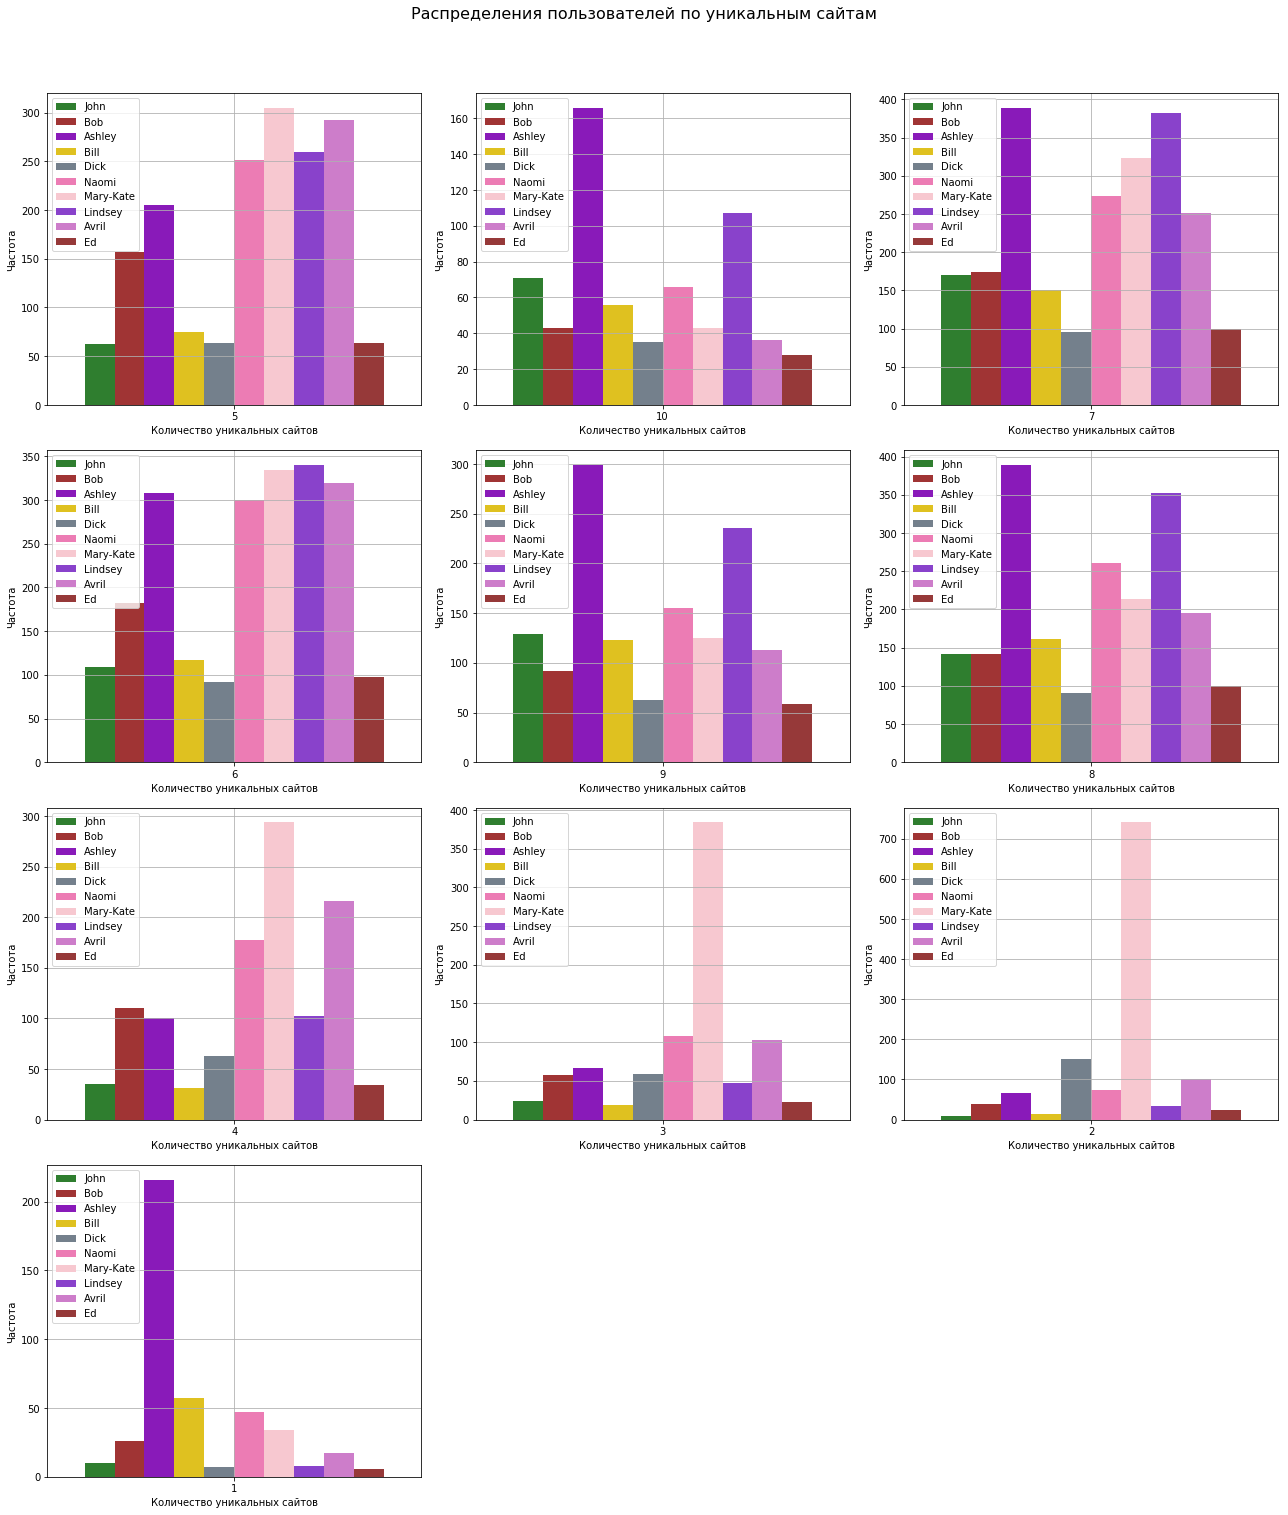

In [106]:
plt.figure(figsize=[18,20])

for i, us in enumerate(new_features['#unique_sites'].unique()):
    # create subplot axes in a 4x3 grid
    ax = plt.subplot(4, 3, i + 1) # nrows, ncols, axes position
    # plot the unique sites on these axes
    sns.countplot(new_features['#unique_sites'][new_features['#unique_sites']== us], 
                  hue='target', data=new_features, palette=color_dic)
    plt.legend(loc=2)
    ax.set_xlabel('Количество уникальных сайтов')
    ax.set_ylabel('Частота')
    plt.grid()

plt.suptitle('Распределения пользователей по уникальным сайтам', y=1.05,  fontsize=16)   
plt.tight_layout();

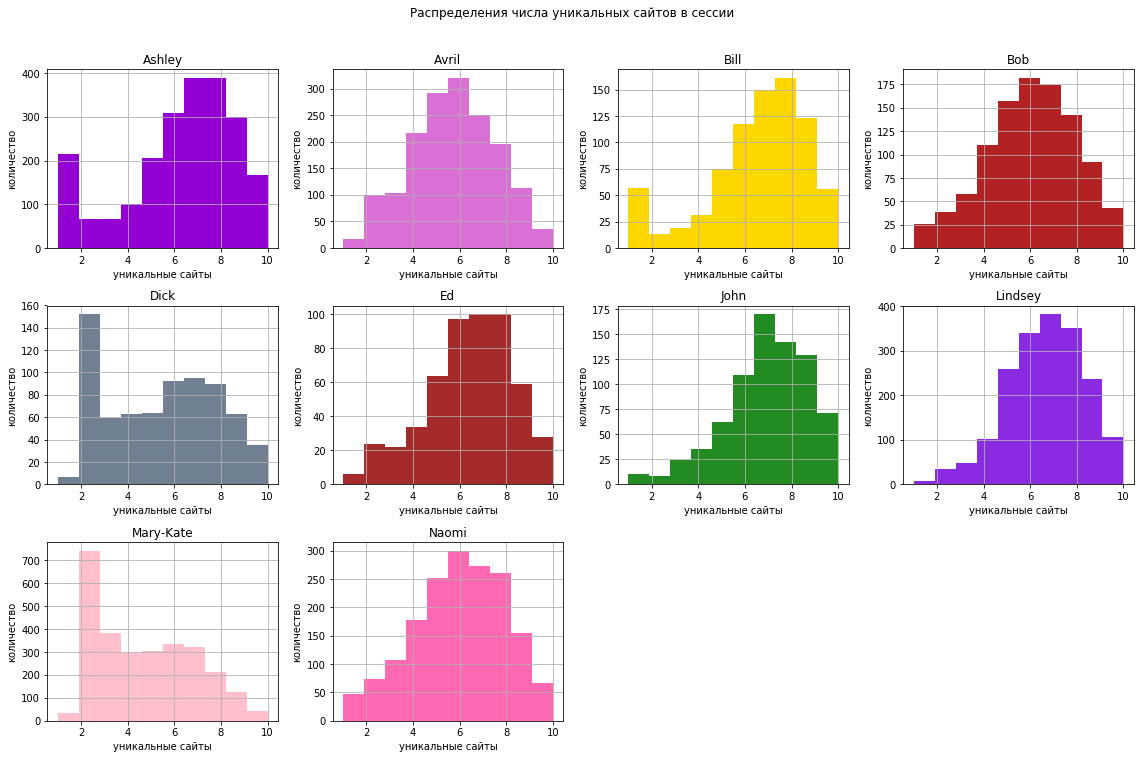

In [105]:
plt.figure(figsize=[16,10])

for i, (user, sub_df) in enumerate(grouped):
    # create subplot axes in a 3x4 grid
    ax = plt.subplot(3, 4, i + 1) # nrows, ncols, axes position
    # plot the unique sites on these axes
    sub_df['#unique_sites'].plot(kind='hist', color=color_dic[user], ax=ax)
    # set the title
    ax.set_title(user)
    ax.set_xlabel('уникальные сайты')
    ax.set_ylabel('количество')
    plt.grid()

plt.suptitle('Распределения числа уникальных сайтов в сессии', y=1.05,  fontsize=12)
plt.tight_layout();

**Для всех пользователей за иключением `'Mary-Kate'` характерно наличие выраженного максимума в диапазоне [6; 8]. Для пользователей `'Mary-Kate'`, `'Ashley'`, `'Bill'`, `'Dick'` также наблюдается максимум в диапазоне [1; 2]. Таким образом распределения `'Ashley'`, `'Bill'`, `'Dick'` имеют выраженную бимодальность.**

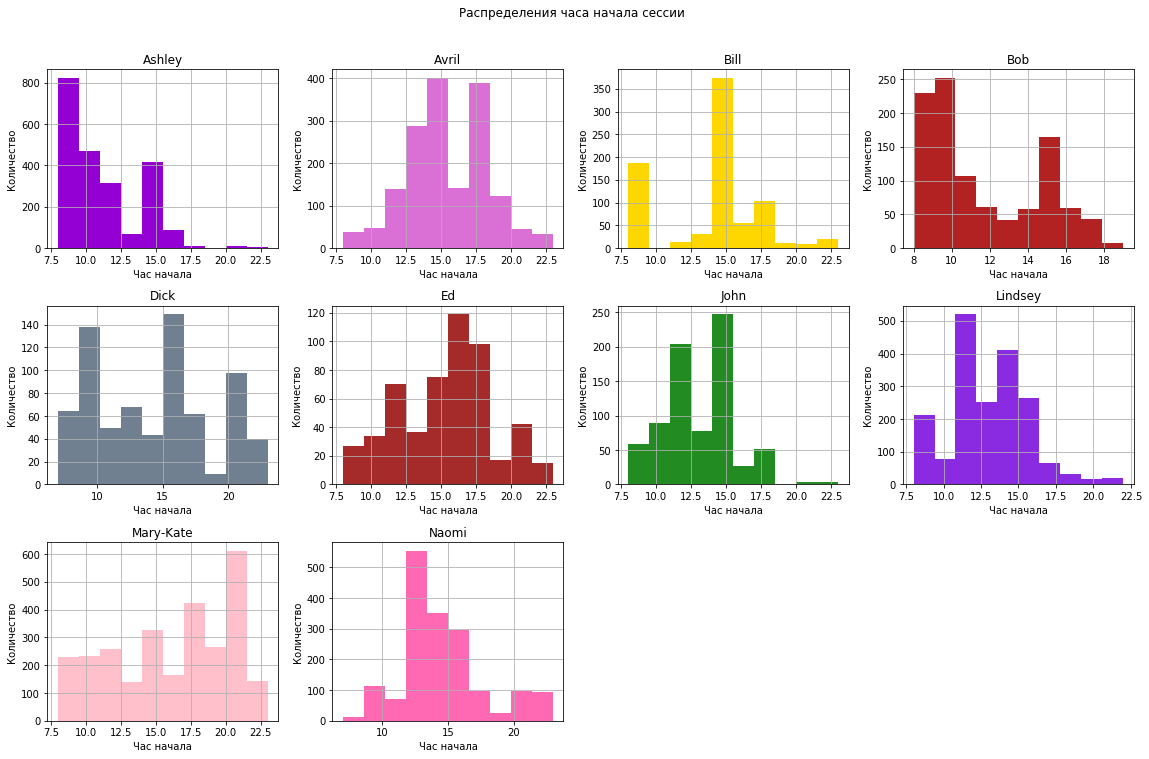

In [107]:
plt.figure(figsize=[16,10])

for i, (user, sub_df) in enumerate(grouped):
    ax = plt.subplot(3, 4, i + 1)
    sub_df['start_hour'].plot(kind='hist', color=color_dic[user], ax=ax)
    ax.set_title(user)
    ax.set_xlabel('Час начала')
    ax.set_ylabel('Количество')
    plt.grid()

plt.suptitle('Распределения часа начала сессии', y=1.05,  fontsize=12)    
plt.tight_layout();

**Для пользователей `'Mary-Kate'`, `'Ashley'`, `'Bill'`, `'Bob'`, `'Dick'` характерно наличие выраженного максимума в утренние часы [8; 10]. Для всех пользователей за иключением `'Mary-Kate'` характерно наличие выраженного максимума в дневные часы [13; 16]. Для пользователей `'Mary-Kate'`, `'Dick'`, `'Ed'`, `'Naomi'` распределение значимо отличается от нуля в вечерние часы >= 20. Визуально гистограммы значительно отличаются друг от друга, поэтому можно ожидать, что этот признак повысит качество предсказаний модели.**

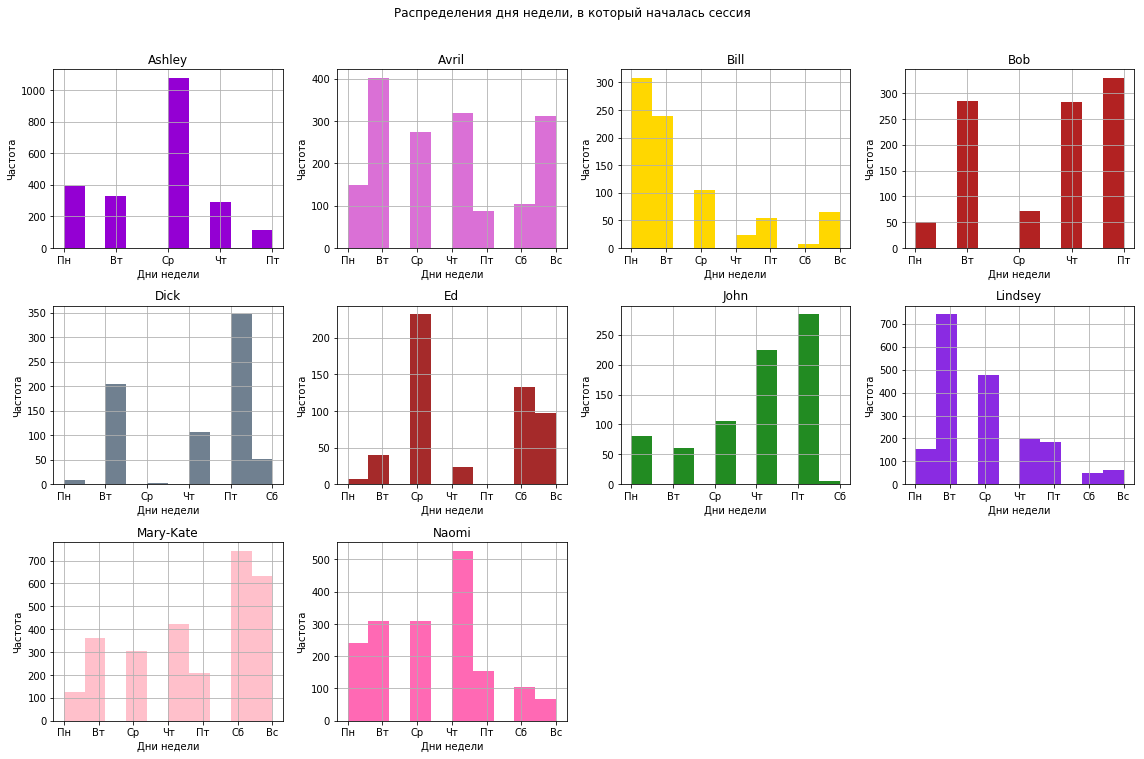

In [108]:
plt.figure(figsize=[16,10])

for i, (user, sub_df) in enumerate(grouped):
    ax = plt.subplot(3, 4, i + 1)
    sub_df['day_of_week'].plot(kind='hist', color=color_dic[user], ax=ax)
    ax.set_xticklabels( ['_', 'Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] )
    ax.set_title(user)
    ax.set_xlabel('Дни недели')
    ax.set_ylabel('Частота')
    plt.grid()

plt.suptitle('Распределения дня недели, в который началась сессия', y=1.05,  fontsize=12)    
plt.tight_layout();

**Пользователи, для которых выражен максимум в выходные дни: `'Mary-Kate'`, `'Dick'`, `'Ed'`, `'Avril'`. Пользователи, для которых выражен максимум в понедельник: 'Bill'. Пользователи, для которых выражен максимум во вторник: `'Avril'`, `'Bob'`, `'Lindsey'`. Пользователи, для которых выражен максимум в среду: `'Ashley'`, `'Dick'`, `'Ed'`. Пользователи, для которых выражен максимум в четверг: `'Naomi'`. Пользователи, для которых выражен максимум в пятницу: `'Bob', 'John'`. На основе сопоставления гистограмм можно сделать вывод, что этот признак более информативен, чем предыдущие, в контексте задачи распознования пользователей.**

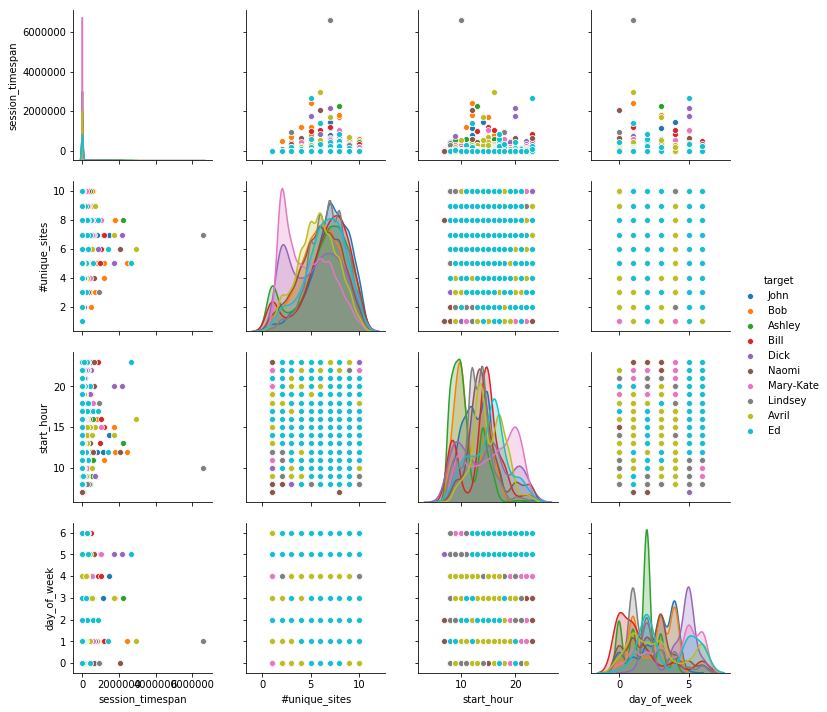

In [99]:
sns.pairplot(new_features[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target']], 
             diag_kind = 'kde', hue = 'target');

**Распределение длинны сессии (`session_timespan`) более-менее одинаково для всех пользователей. Поэтому этот признак скорее всего неинформативен в контексте задачи распознования пользователей и его не следует включать в модель.**

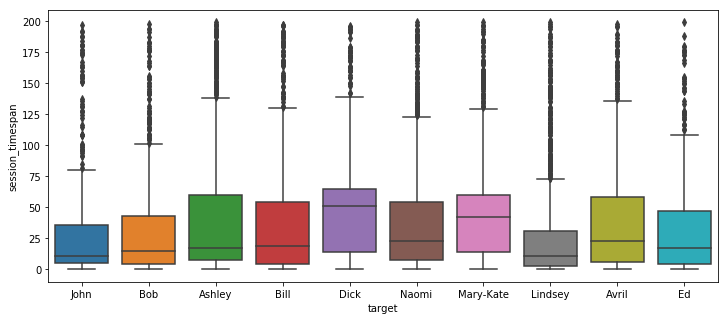

In [101]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(y = 'session_timespan', x = 'target', 
            data= new_features[['session_timespan','target']][new_features['session_timespan']<200], ax = ax);

**Топ-10 самых посещаемых сайтов (top10_sites) и соответствующие кол-ва посещений (top10_freqs).**

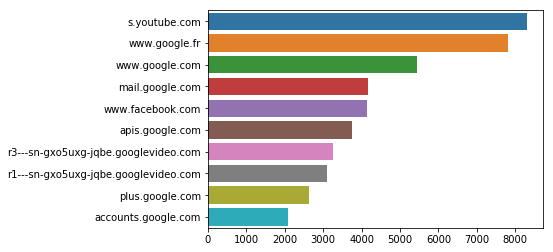

In [102]:
top10 = pd.DataFrame(site_freq_10users).T.reset_index().iloc[:, [0, 2]].\
                    sort_values(by=1, ascending=False).head(10)

top10_freqs = top10[1].values
top10_sites = top10['index'].values

sns.barplot(top10_freqs, top10_sites);

**В топ-10 популярных сайтов находятся сервисы youtube, google и facebook.**